In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import seaborn as sns


In [13]:
class Distribution(nn.Module):
    def __init__(self, size=1000):
        super().__init__()
        self.mu = nn.Parameter(torch.tensor(0.0), requires_grad=True)
        self.std = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.size = size
        self.normal_dis = torch.normal(0, 1, size=(1, self.size)).flatten()
    def forward(self):
        return self.mu + self.std * torch.normal(0, 1, size=(1, self.size)).flatten()

class LinearRegression(nn.Module):
    def __init__(self, size=1000):
        super().__init__()
        self.m = Distribution(size=size)
        self.b = Distribution(size=size)
        self.noise = nn.Parameter(torch.tensor(1.0), requires_grad=True)
        self.losses = []
    def forward(self, x, y):
        m = self.m()
        b = self.b()
        x = torch.tensor(x)
        y = torch.tensor(y)
        
        total_loss = (((y - (torch.einsum('m,x -> xm', m, x) + b).transpose(0, 1)) ** 2).sum(axis=0) * (1 / len(m))).sum() * (1 / len(x))
        
        total_loss *= (1 / (2 * self.noise ** 2))
        total_loss += ((len(x) / 2) * torch.log(self.noise ** 2)) / len(x)
        
        self.losses.append(total_loss.item())
        
        # Minimize loss by maximizing this value
        return total_loss

In [9]:
def training(x, y, epochs=5):
    model = LinearRegression()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in tqdm(range(epochs), desc="Training..."):
        # Zeros gradiant for training
        optimizer.zero_grad()
        
        # Calculates likelihood
        loglik = model(x, y)
        e = torch.mean(loglik)
        
        # Updates parameters
        e.backward()
        optimizer.step()
        
    return model

In [10]:
df = pd.read_csv('data/Advertising.csv').drop('Unnamed: 0', axis=1)
df

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9
...,...,...,...,...
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5


In [11]:
x = df.TV.to_numpy()
y = df.Sales.to_numpy()

In [14]:
res = training(x, y, epochs=10000)
res

Training...: 100%|██████████| 10000/10000 [02:01<00:00, 82.33it/s]


LinearRegression(
  (m): Distribution()
  (b): Distribution()
)

<AxesSubplot: >

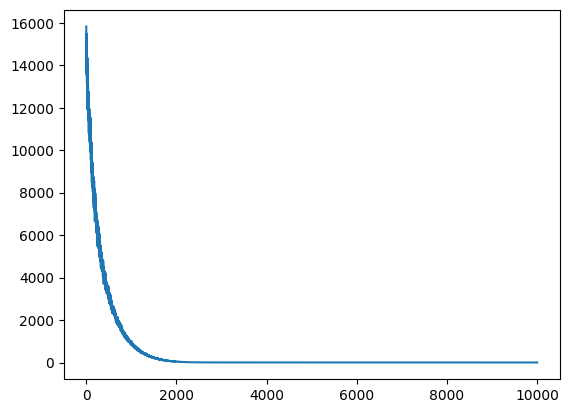

In [16]:
sns.lineplot(x = range(len(res.losses)), y = res.losses)

In [17]:
print(res.m.mu)

Parameter containing:
tensor(0.0526, requires_grad=True)


In [18]:
print(res.m.std)

Parameter containing:
tensor(-9.0270e-09, requires_grad=True)


In [19]:
print(res.b.mu)

Parameter containing:
tensor(6.0372, requires_grad=True)


In [20]:
print(res.b.std)

Parameter containing:
tensor(0.0002, requires_grad=True)


In [21]:
print(res.noise)

Parameter containing:
tensor(1.5769, requires_grad=True)
